<H1>Prédire le taux de Churn des clients</H1>

**TELCO Inc.** est une entreprise de téléphonie confrontée à un problème de désabonnement (churn). Ils ont collecté un ensemble de données sur leurs anciens clients et vous demandent de :

1. **Classer leurs clients en fonction de la probabilité de désabonnement.**
2. **Déterminer quels clients devraient être contactés et quel devrait être le rabais personnalisé à proposer afin de maximiser le futur profit de TELCO Inc.** (en tenant compte du compromis entre la prévention du désabonnement et la réduction du profit par client après rabais).

**Il y a un coût fixe de 10 € pour contacter un client.**

### Données disponibles

L'ensemble de données contient deux fichiers :

1. **Ensemble d'entraînement** : comprend les étiquettes dans la colonne `CHURNED`.
2. **Ensemble de test** : contient les mêmes colonnes que l'ensemble d'entraînement, mais sans les étiquettes.


<H2>Importation des données</H2>

Import packages

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


import data

In [252]:
train_path = 'data/training.csv'
test_path = 'data/validation.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [289]:
train_df.describe()

,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000
mean,503.625376,47595.943703,80.185460,23.785577,504574.112553,2.070194,2.508639,155.541941,383.495868,7.540356,3.079250,5.972957
std,457.156513,22293.736749,84.587419,26.680037,250045.163657,1.249974,1.120546,47.905580,210.601172,8.768863,1.650221,4.361189
min,0.000000,10032.500000,-2.000000,0.000000,150015.000000,0.000000,1.000000,50.000000,130.000000,0.000000,0.300000,1.000000
25%,181.818182,29367.000000,0.000000,0.000000,276076.000000,1.000000,2.000000,121.000000,217.000000,1.000000,1.900000,2.000000
50%,360.995851,44992.500000,56.000000,15.000000,469775.500000,2.000000,3.000000,149.000000,322.000000,4.000000,2.700000,5.000000
75%,685.714286,65078.000000,171.000000,41.000000,710275.000000,3.000000,4.000000,182.000000,515.000000,13.000000,3.800000,9.000000
max,6600.000000,105355.500000,298.000000,89.000000,999996.000000,7.000000,4.000000,521.000000,899.000000,29.000000,21.000000,15.000000


**Ensemble d'entraînement**

- **Nombre d'enregistrements** : 11 981
- **Nombre de colonnes** : 32

### Colonnes de l'Ensemble d'Entraînement

1. **Identifiant Client** : `CUSTOMER_ID`
2. **Statut de Désabonnement** : `CHURNED` (étiquette cible)
3. **Caractéristiques Numériques** :
   - `DATA`
   - `INCOME`
   - `OVERCHARGE`
   - `LEFTOVER`
   - `HOUSE`
   - `CHILD`
   - `REVENUE`
   - `HANDSET_PRICE`
   - `OVER_15MINS_CALLS_PER_MONTH`
   - `TIME_CLIENT`
   - `AVERAGE_CALL_DURATION`

4. **Caractéristiques Catégorielles** :
   - `COLLEGE`
   - `JOB_CLASS`
   - `REPORTED_SATISFACTION`
   - `REPORTED_USAGE_LEVEL`
   - `CONSIDERING_CHANGE_OF_PLAN`

In [256]:
train_df.CHURNED.value_counts()

CHURNED
STAY     7612
LEAVE    4369
Name: count, dtype: int64

In [253]:
train_df.isnull().sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

<Axes: >

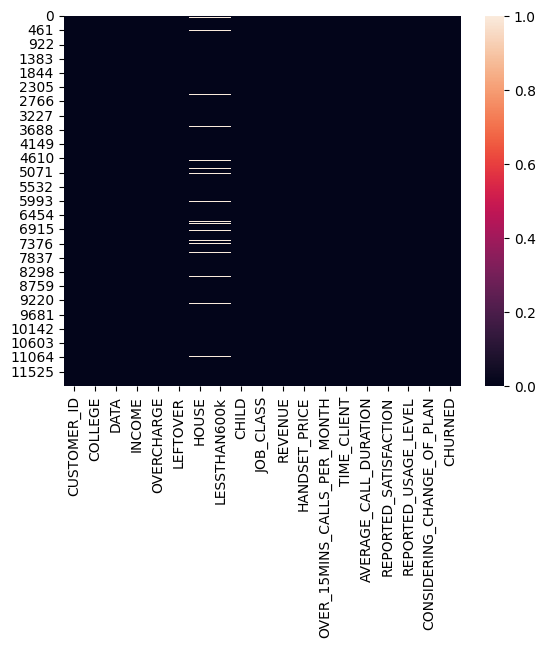

In [258]:
sns.heatmap(train_df.isnull())

La colonne `HOUSE` et  `LESSTHAN600k` ont des valeurs manquantes

In [259]:
train_df['HOUSE'].fillna(train_df['HOUSE'].median(), inplace=True)

/tmp/ipykernel_969185/2199400847.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['HOUSE'].fillna(train_df['HOUSE'].median(), inplace=True)


Pour traiter les valeurs manquantes dans la colonne HOUSE en utilisant la médiane,

In [260]:
train_df['LESSTHAN600k'].fillna(train_df['LESSTHAN600k'].mode()[0], inplace=True)

/tmp/ipykernel_969185/1050717564.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['LESSTHAN600k'].fillna(train_df['LESSTHAN600k'].mode()[0], inplace=True)
/tmp/ipykernel_969185/1050717564.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['LESSTHAN600k'].fillna(train_df['LESSTHAN600k'].mod

Pour traiter les valeurs manquantes dans la colonne LESSTHAN600k en utilisant la valeur modale (la valeur la plus fréquente)

<H2>Exploration des données</H2>

La distribution des variables catégorielles en fonction des clients ayant ou n'ayant pas quitté l'entreprise.

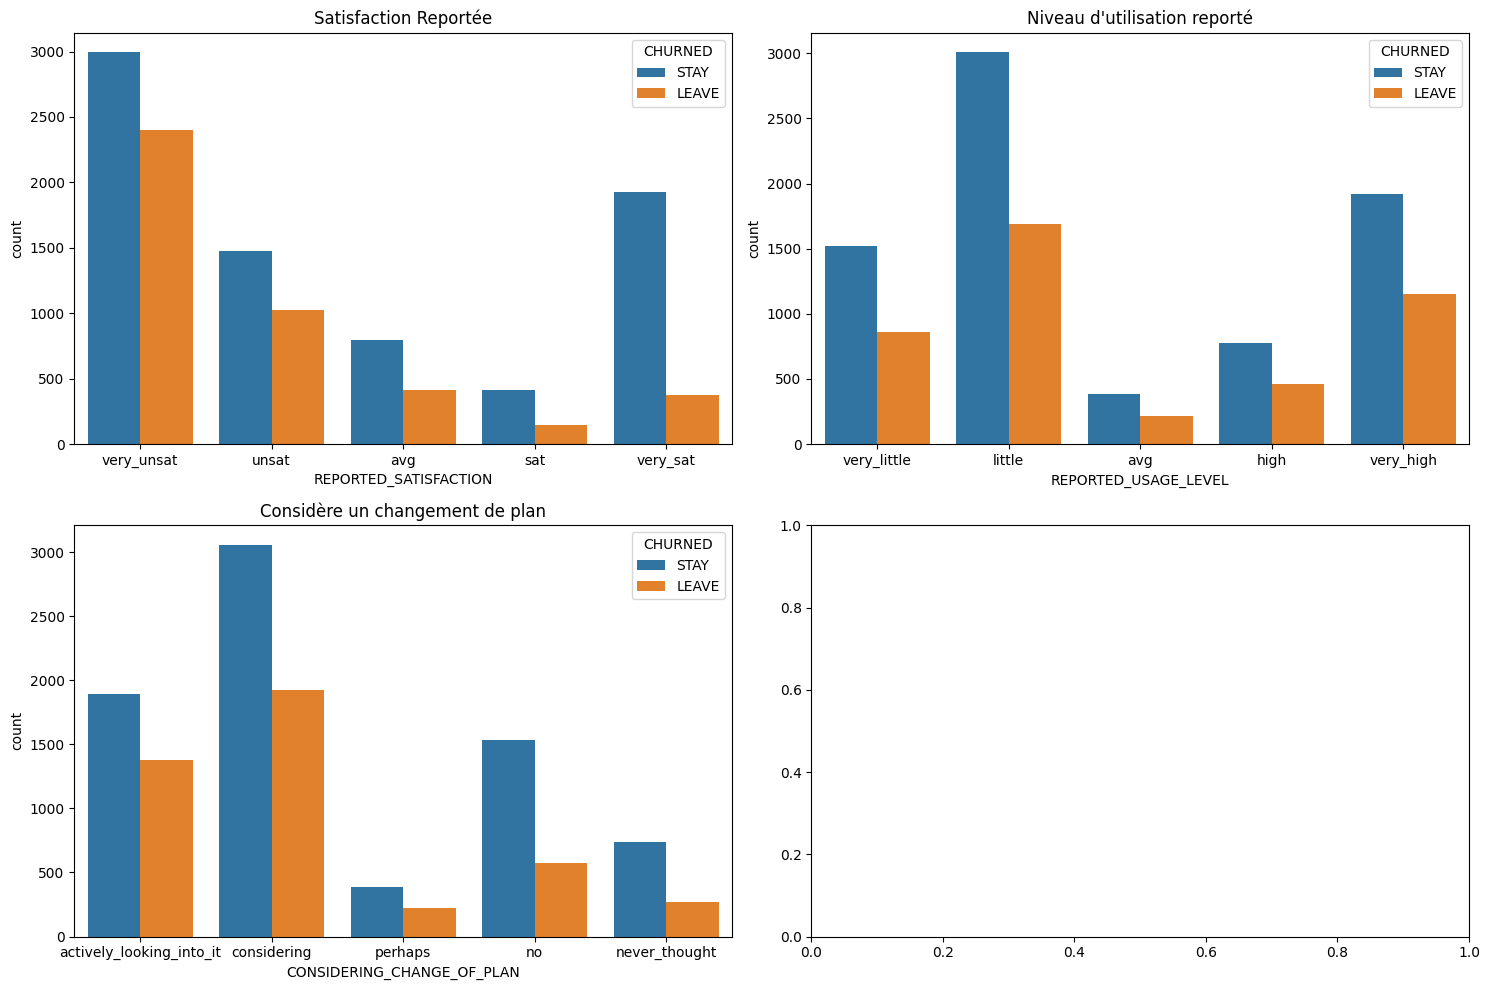

In [262]:
# Variables catégorielles
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(x='REPORTED_SATISFACTION', hue='CHURNED', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Satisfaction Reportée')

sns.countplot(x='REPORTED_USAGE_LEVEL', hue='CHURNED', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Niveau d\'utilisation reporté')
train_df
sns.countplot(x='CONSIDERING_CHANGE_OF_PLAN', hue='CHURNED', data=train_df, ax=axes[1, 0])
axes[1, 0].set_title('Considère un changement de plan')

plt.tight_layout()
plt.show()


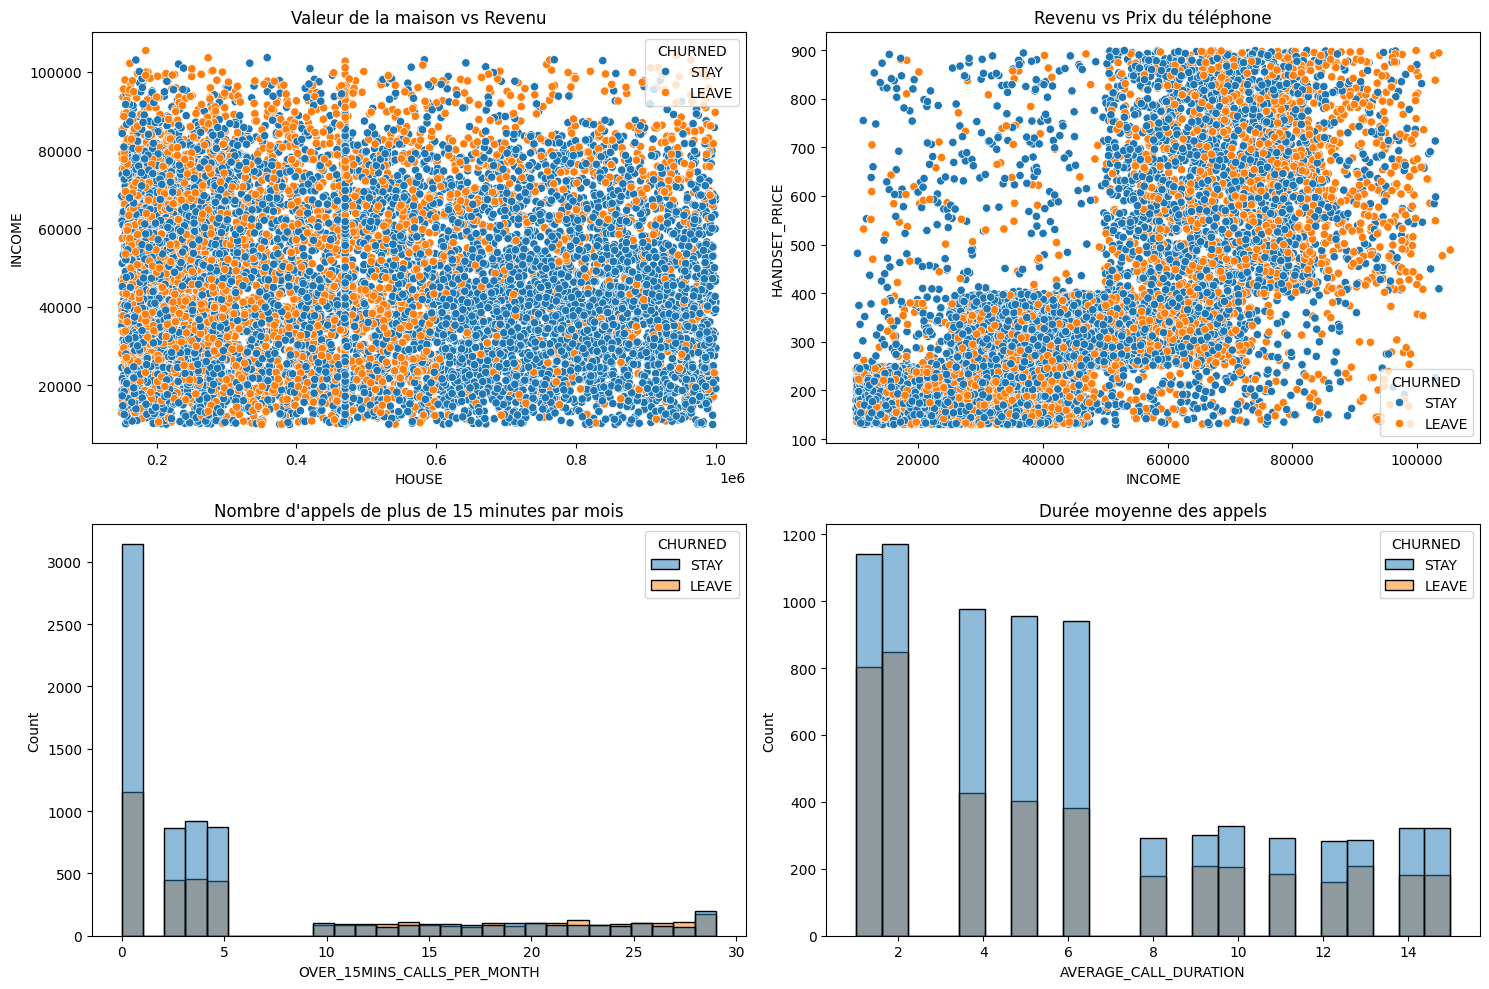

In [263]:
# Variables continues
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x='HOUSE', y='INCOME', hue='CHURNED', data=train_df, ax=axes[0, 0])
axes[0, 0].set_title('Valeur de la maison vs Revenu')

sns.scatterplot(x='INCOME', y='HANDSET_PRICE', hue='CHURNED', data=train_df, ax=axes[0, 1])
axes[0, 1].set_title('Revenu vs Prix du téléphone')

sns.histplot(x='OVER_15MINS_CALLS_PER_MONTH', hue='CHURNED', data=train_df, ax=axes[1, 0], kde=False)
axes[1, 0].set_title('Nombre d\'appels de plus de 15 minutes par mois')

sns.histplot(x='AVERAGE_CALL_DURATION', hue='CHURNED', data=train_df, ax=axes[1, 1], kde=False)
axes[1, 1].set_title('Durée moyenne des appels')

plt.tight_layout()
plt.show()


In [264]:
train_df.describe()

,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000
mean,503.625376,47595.943703,80.185460,23.785577,504574.112553,2.070194,2.508639,155.541941,383.495868,7.540356,3.079250,5.972957
std,457.156513,22293.736749,84.587419,26.680037,250045.163657,1.249974,1.120546,47.905580,210.601172,8.768863,1.650221,4.361189
min,0.000000,10032.500000,-2.000000,0.000000,150015.000000,0.000000,1.000000,50.000000,130.000000,0.000000,0.300000,1.000000
25%,181.818182,29367.000000,0.000000,0.000000,276076.000000,1.000000,2.000000,121.000000,217.000000,1.000000,1.900000,2.000000
50%,360.995851,44992.500000,56.000000,15.000000,469775.500000,2.000000,3.000000,149.000000,322.000000,4.000000,2.700000,5.000000
75%,685.714286,65078.000000,171.000000,41.000000,710275.000000,3.000000,4.000000,182.000000,515.000000,13.000000,3.800000,9.000000
max,6600.000000,105355.500000,298.000000,89.000000,999996.000000,7.000000,4.000000,521.000000,899.000000,29.000000,21.000000,15.000000


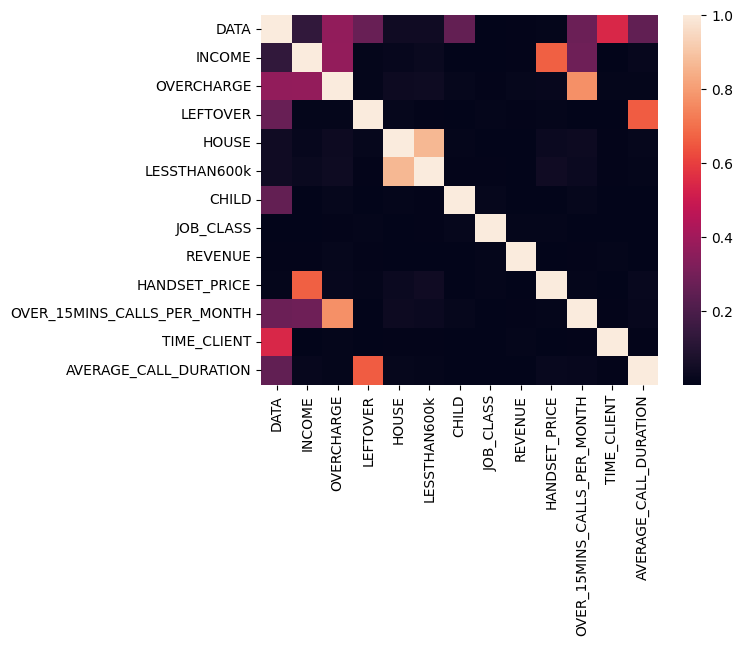

Pairs of features with correlation higher than 0.8:
LESSTHAN600k, HOUSE : 0.8644930915781843


In [267]:

#Création d'une carte de chaleur pour la matrice de corrélation
sns.heatmap(corr_matrix)

# Affichage du graphique
plt.show()
#Finding pairs of features with correlation higher than the threshold
high_corr_pairs = [(col1, col2) for col1 in upper.columns for col2 in upper.columns if upper[col1][col2] > threshold and col1 != col2]

# Displaying highly correlated pairs and their correlation values
print("Pairs of features with correlation higher than 0.8:")
for col1, col2 in high_corr_pairs:963

print(f"{col1}, {col2} : {upper[col1][col2]}")

In [266]:
#Finding pairs of features with correlation higher than the threshold
high_corr_pairs = [(col1, col2) for col1 in upper.columns for col2 in upper.columns if upper[col1][col2] > threshold and col1 != col2]

# Displaying highly correlated pairs and their correlation values
print("Pairs of features with correlation higher than 0.8:")
for col1, col2 in high_corr_pairs:963

print(f"{col1}, {col2} : {upper[col1][col2]}")

Pairs of features with correlation higher than 0.8:
LESSTHAN600k, HOUSE : 0.8644930915781843


In [265]:
num_cols = train_df._get_numeric_data().columns
corr_matrix = train_df[num_cols].corr().abs()

threshold = 0.8
# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold )]

# Print features to drop
print(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")

The following 1 features will be dropped due to high correlation: ['LESSTHAN600k']


In [268]:
train_df = train_df.drop(to_drop, axis = 1)

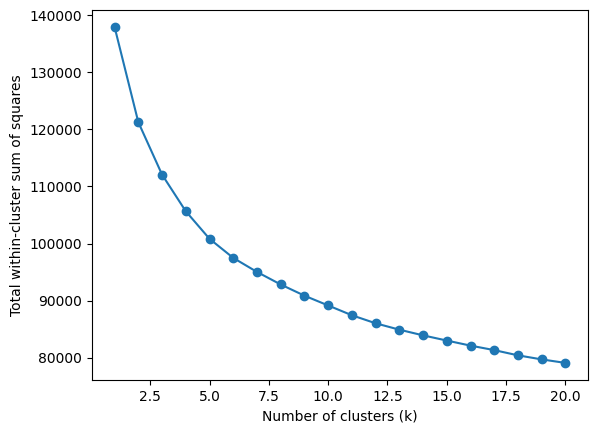

In [242]:
# K-means Clustering
data_numeric = train_df.select_dtypes(include=[np.number])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
from sklearn.cluster import KMeans
ratios = [KMeans(n_clusters=k, n_init=20, random_state=1).fit(data_scaled).inertia_ for k in range(1, 21)]
plt.plot(range(1, 21), ratios, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total within-cluster sum of squares')
plt.show()



In [233]:
train_df

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,no,660.000000,19995.0,0,0,897338.0,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,yes,317.647059,31477.0,155,15,393396.0,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,no,208.695652,66742.0,0,13,937197.0,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,no,265.017668,40864.0,183,0,986430.0,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,yes,440.000000,43321.5,200,0,394622.0,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,C115967,yes,829.787234,40567.0,41,7,458723.0,0,4,128.0,305,5,3.9,4,avg,little,actively_looking_into_it,STAY
11977,C115968,no,723.529412,75007.5,70,0,328171.0,3,1,199.0,610,5,4.1,13,unsat,little,actively_looking_into_it,LEAVE
11978,C115970,no,80.000000,77674.5,0,80,439967.0,3,1,94.0,750,1,1.4,1,unsat,little,actively_looking_into_it,LEAVE
11979,C115972,no,77.777778,37730.5,0,17,795808.0,3,1,142.0,284,0,1.7,8,very_unsat,little,considering,STAY


In [274]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


data_numeric = train_df.select_dtypes(include=[np.number])
scaler = StandardScaler()
# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
clusters = kmeans.fit_predict(data_numeric)

# Ajouter les informations de cluster à X_train
X_train_with_clusters = pd.DataFrame(train_df)
X_train_with_clusters['cluster'] = clusters

In [275]:
X_train_with_clusters

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED,cluster
0,C100000,no,660.000000,19995.0,0,0,897338.0,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY,0
1,C100001,yes,317.647059,31477.0,155,15,393396.0,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE,1
2,C100006,no,208.695652,66742.0,0,13,937197.0,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY,0
3,C100008,no,265.017668,40864.0,183,0,986430.0,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE,0
4,C100010,yes,440.000000,43321.5,200,0,394622.0,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,C115967,yes,829.787234,40567.0,41,7,458723.0,0,4,128.0,305,5,3.9,4,avg,little,actively_looking_into_it,STAY,1
11977,C115968,no,723.529412,75007.5,70,0,328171.0,3,1,199.0,610,5,4.1,13,unsat,little,actively_looking_into_it,LEAVE,2
11978,C115970,no,80.000000,77674.5,0,80,439967.0,3,1,94.0,750,1,1.4,1,unsat,little,actively_looking_into_it,LEAVE,1
11979,C115972,no,77.777778,37730.5,0,17,795808.0,3,1,142.0,284,0,1.7,8,very_unsat,little,considering,STAY,0


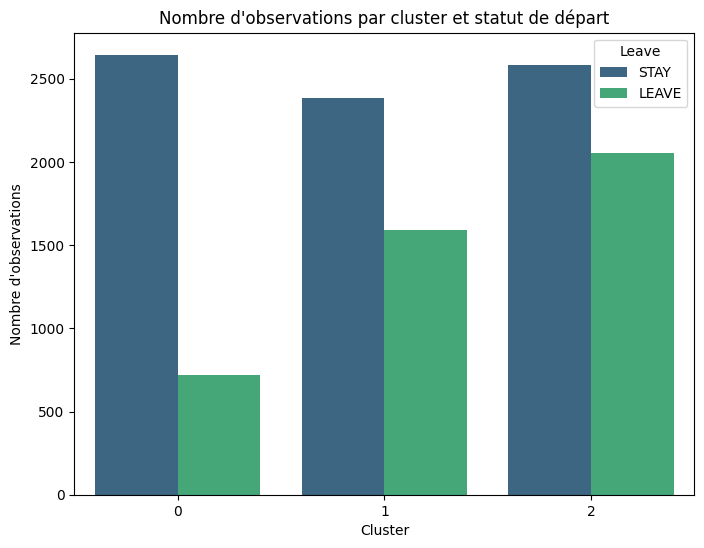

In [276]:
# Création du graphique
plt.figure(figsize=(8, 6))
sns.countplot(data=X_train_with_clusters, x='cluster', hue='CHURNED', palette='viridis')

# Personnalisation du graphique
plt.title('Nombre d\'observations par cluster et statut de départ')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'observations')
plt.legend(title='Leave')
plt.show()

In [279]:

def load_and_preprocess_data(train_df, test_df): 
    categorical_cols = ['COLLEGE', 'JOB_CLASS', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']
    numerical_cols = ['DATA', 'INCOME', 'OVERCHARGE', 'LEFTOVER', 'HOUSE', 'CHILD', 'REVENUE', 'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT', 'AVERAGE_CALL_DURATION']
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)])
    
    # Séparer les caractéristiques et la cible
    X = train_df.drop(columns=['CUSTOMER_ID', 'CHURNED'])
    y = train_df['CHURNED']

    # Diviser en ensembles d'entraînement et de test
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Prétraiter les données
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(test_df.drop(columns=['CUSTOMER_ID']))
    
    # Récupérer les identifiants des clients pour l'ensemble de test
    test_ids = test_df['CUSTOMER_ID']
    
    return X_train, X_valid, y_train, y_valid, X_test, test_ids

# Exemple d'utilisation
# Assurez-vous que train_df et test_df sont déjà définis comme DataFrames pandas
X_train, X_valid, y_train, y_valid, X_test, test_ids = load_and_preprocess_data(train_df, test_df)

Logistic Regression: ROC AUC = 0.7450
Random Forest: ROC AUC = 0.8281
Decision Tree: ROC AUC = 0.6741
SVM: ROC AUC = 0.8141
Gradient Boosting: ROC AUC = 0.8421


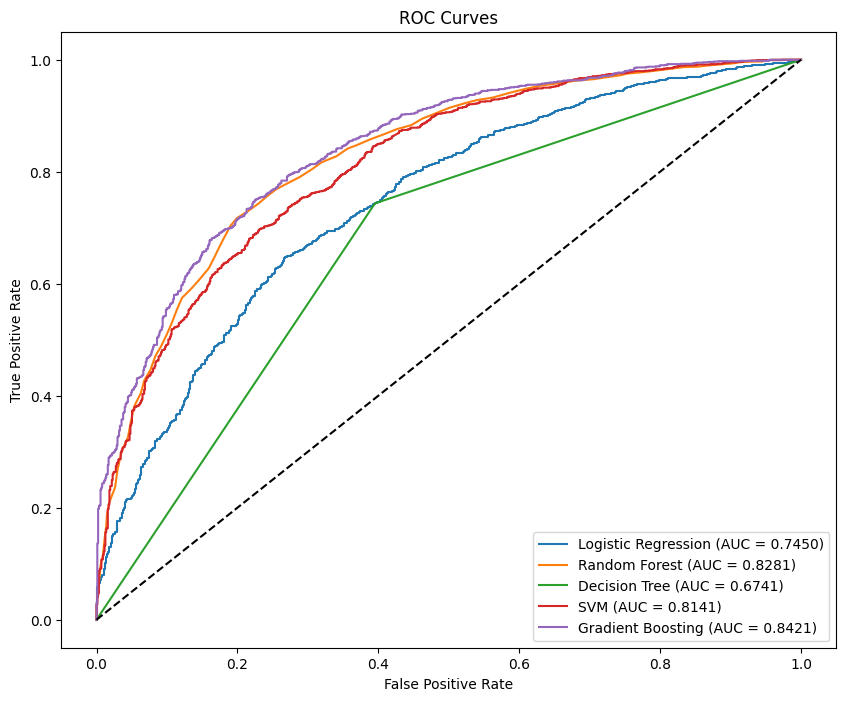

In [280]:
from sklearn.preprocessing import LabelBinarizer

# Convertir les étiquettes en valeurs binaires
lb = LabelBinarizer()
y_valid_binary = lb.fit_transform(y_valid).ravel()  # Convertir y_valid en valeurs binaires (0, 1)

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid_binary, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid_binary, y_pred_proba)
    results[name] = {'model': model, 'auc': auc_score, 'fpr': fpr, 'tpr': tpr}

# Afficher les scores AUC
for name, result in results.items():
    print(f'{name}: ROC AUC = {result["auc"]:.4f}')

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


/home/aicha/Bureau/stage/telco-churn-prediction/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/aicha/Bureau/stage/telco-churn-prediction/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/home/aicha/Bureau/stage/telco-churn-prediction/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aicha/Bureau/stage/telco-churn-prediction/venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/aicha/B

Logistic Regression - F1 Score: nan ± nan
Logistic Regression - Accuracy: 0.7253 ± 0.0068

Random Forest - F1 Score: nan ± nan
Random Forest - Accuracy: 0.7693 ± 0.0032

Decision Tree - F1 Score: nan ± nan
Decision Tree - Accuracy: 0.6913 ± 0.0061

SVM - F1 Score: nan ± nan
SVM - Accuracy: 0.7588 ± 0.0098

Gradient Boosting - F1 Score: nan ± nan
Gradient Boosting - Accuracy: 0.7827 ± 0.0127

Logistic Regression: ROC AUC = 0.7450
Random Forest: ROC AUC = 0.8281
Decision Tree: ROC AUC = 0.6741
SVM: ROC AUC = 0.8141
Gradient Boosting: ROC AUC = 0.8421


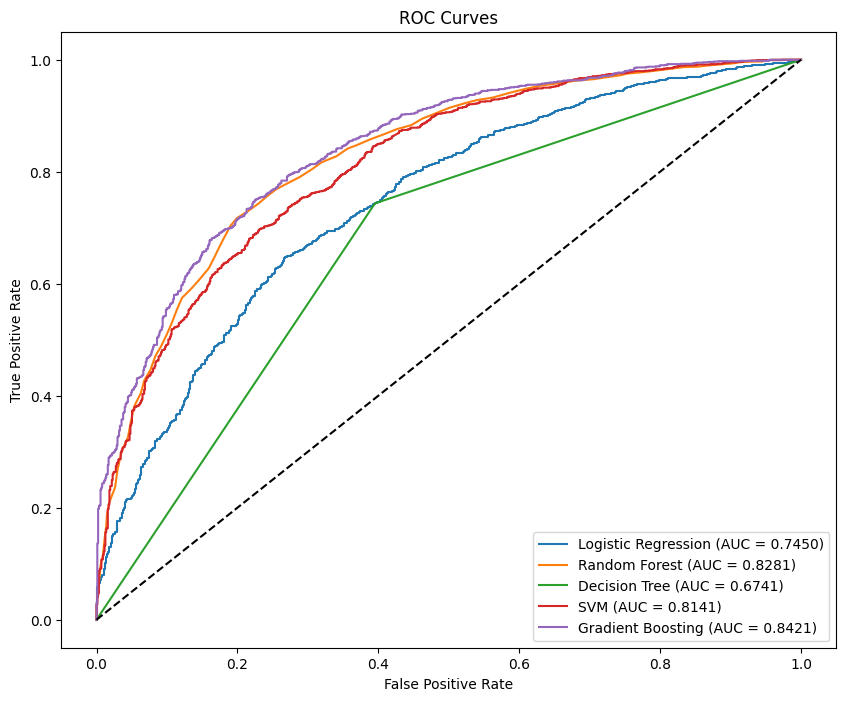

In [285]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

# Définir le scorer pour la validation croisée
scorer = {
    'accuracy': 'accuracy',
    'f1': make_scorer(f1_score)
}

# Dictionnaire pour stocker les résultats de la validation croisée
cv_results = {}

# Effectuer la validation croisée pour chaque modèle
for name, model in models.items():
    cv_result = cross_validate(model, X_train, y_train, cv=5, scoring=scorer)
    cv_results[name] = {
        'f1_mean': cv_result['test_f1'].mean(),
        'f1_std': cv_result['test_f1'].std(),
        'accuracy_mean': cv_result['test_accuracy'].mean(),
        'accuracy_std': cv_result['test_accuracy'].std()
    }

# Afficher les scores de validation croisée
for name, result in cv_results.items():
    print(f'{name} - F1 Score: {result["f1_mean"]:.4f} ± {result["f1_std"]:.4f}')
    print(f'{name} - Accuracy: {result["accuracy_mean"]:.4f} ± {result["accuracy_std"]:.4f}')
    print()

# Ré-évaluer les modèles sur l'ensemble de validation pour les courbes ROC
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc_score = roc_auc_score(y_valid_binary, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_valid_binary, y_pred_proba)
    results[name] = {'model': model, 'auc': auc_score, 'fpr': fpr, 'tpr': tpr}

# Afficher les scores AUC
for name, result in results.items():
    print(f'{name}: ROC AUC = {result["auc"]:.4f}')

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


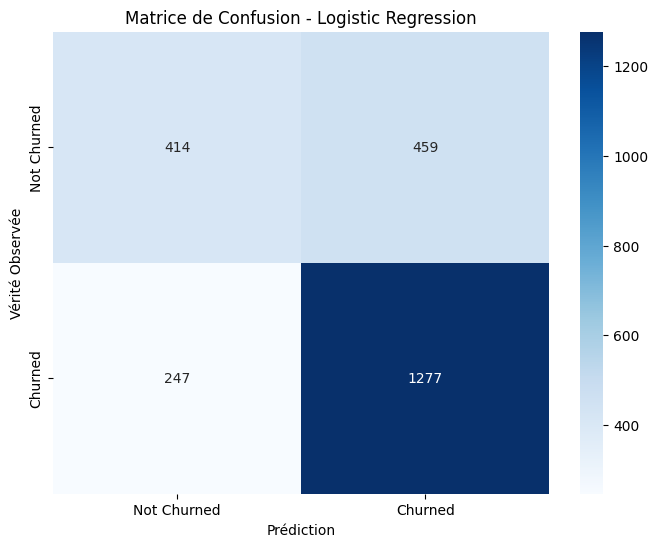

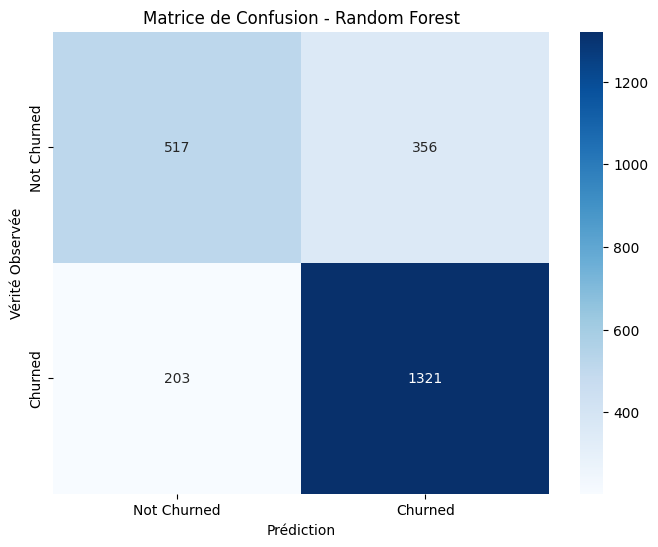

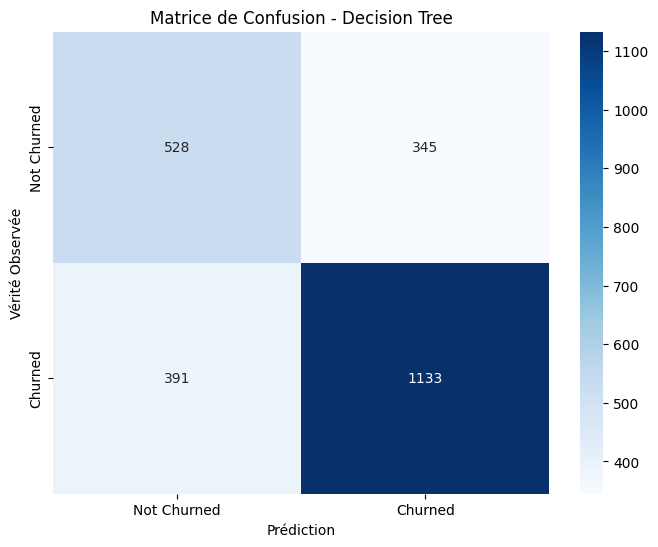

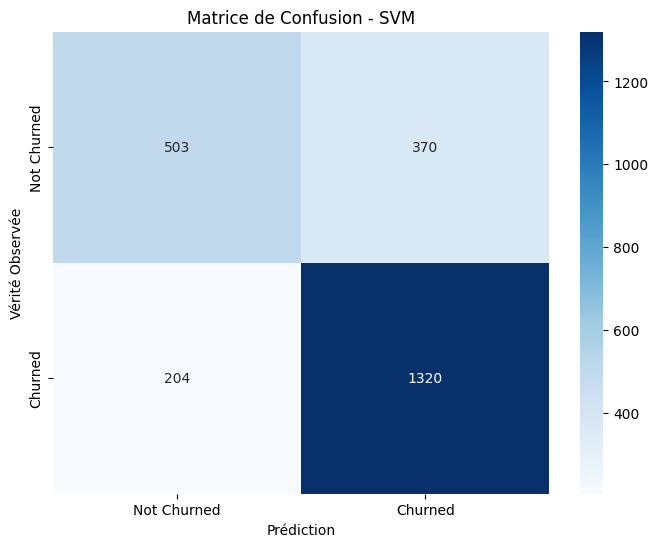

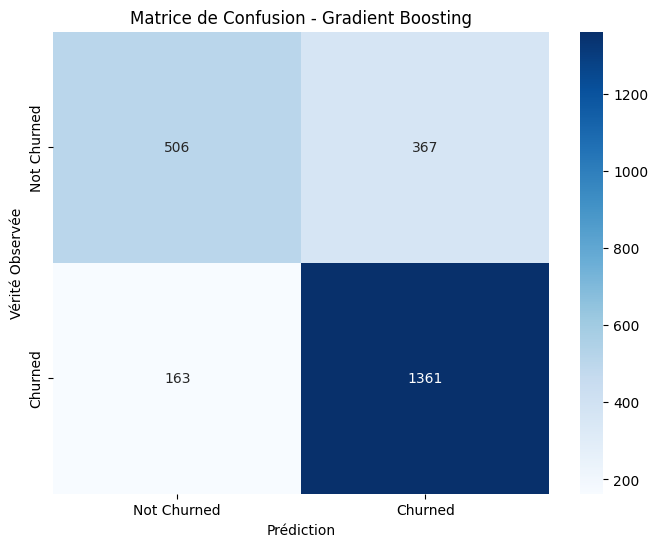

In [286]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.title(f'Matrice de Confusion - {name}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité Observée')
    plt.show()

In [284]:

def predict(model, X_test):
    return model.predict_proba(X_test)[:, 1]

predictions = predict(models['Gradient Boosting'], X_test)


In [287]:
output_df = pd.DataFrame({
    'CUSTOMER_ID': test_ids,
    'CHURN_PROBABILITY': predictions,
    'CHURN_LABEL': ['LEAVE' if prob > 0.5 else 'STAY' for prob in predictions],
    'CLIENT_TO_CONTACT': ['YES' if prob > 0.5 else 'NO' for prob in predictions],
    'DISCOUNT': [min(10 / prob, 50) if prob > 0.5 else 0 for prob in predictions]
})

output_path = 'data/output.csv'
output_df.to_csv(output_path, index=False)
print(f'Résultats sauvegardés dans {output_path}')

Résultats sauvegardés dans data/output.csv
